# The Shapiro-Wilk Normacy Test


In these notes, I want to walk through the reasoning behind the original [*An analysis of variance test for normality* 1965 paper by Shapiro and Wilk](https://sci2s.ugr.es/keel/pdf/algorithm/articulo/shapiro1965.pdf). This paper is the first to propose what is now known as the Shapiro-Wilk test of normality. I came accross this test while trying to learn more about time series statistics, but I had a hard time finding any information about the test. It turns out the best documentation on the test was the original paper. I am posting this because it was difficult for me to track down information about the Shapiro-Wilk test online, and maybe it will save some time for some readers.

The best information I *was* able to find came from [this blog post](https://www.real-statistics.com/tests-normality-and-symmetry/statistical-tests-normality-symmetry/shapiro-wilk-test/) listing the steps of the computation and this [Fortran implementation](http://lib.stat.cmu.edu/apstat/R94). In fact that later implementation is the one that [SciPy calls](https://github.com/scipy/scipy/blob/master/scipy/stats/morestats.py#L1609) to implement the test.

The [Wikipedia article](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test) on the test lists a simple formula:

$$ W = \frac{\big(\sum_{n=1}^N a_i x_i\big)^2}{\sum_{i=1}^n (x_i - \bar{x})^2}$$

where

$$ \vec{a} = \frac{m^T V^{-1}}{C} $$

where 

$$ C = \lVert V^{-1}m \rVert $$

where

$m$ "is made of the expected values of the order statistics of independent and identically distributed random variables sampled from the standard normal distribution; finally, $V$ is the covariance matrix of those normal order statistics".

None of that looks too hard to calculate. This could be done in a few lines with [NumPy](https://numpy.org/), but we need to decode the meaning of $m$ and $V$. It is not at all clear how the magic numbers used in the Fortran implementation correspond to this description. (In fact, even at the time of posting, I still do not understand the source for those numbers.)

TODO(gs): Figure out and document how the R94 Shapiro-Wilk implementation works.

It looks like we need to go back to the original paper.

 I will not use any libraries other than SciPy and [Matplotlib](https://matplotlib.org/).
However, SciPy use will be restricted to the `array` and `linalg` modules. 

Now to calculate the W statistic.

## Order Statistics

*(Some of this section is pulled from [Kim Border's lecture notes](http://www.math.caltech.edu/~2016-17/2term/ma003/Notes/Lecture14.pdf).)*

We follow the definition in the paper exactly. The first step is to calculate the order statistics.
 
"Let $m^\prime = (m_1,m_2,..., m_n)$ denote the vector of expected values of the standard normal order statistics."

The $k$-th order statistic for a sample is given by the $k$-th least element of the sample. We wish to calculate an expected value for an order statistic. In particular, we are looking for an expression to find the expected value for the $k$-th order statistic from a sample of $n$ elements from a probability distribution given by PDF $\rho$. Call the random variable for this order statistic $X_{k,n}$, and the underlying random variable $X$. 

Therefore:

$$ (X_{k,n} \leq x) = (X_{n,n} \leq x) \cup (X_{n,n} > x, X_{n-1,n} \leq x) \cup ... \cup (X_{k+1,n} > x, X_{k,n} \leq x)$$

Each of these conditions is disjoint and therefore we can add the probabilities to find the PDF for $X_{k,n}$.

Before moving on, we should note that

$$ P(X \leq x) = \int_{-\infty}^x d\tau \rho(x) $$

We can simplify by defining $F(x) \equiv P(X \leq x)$ so that $F^\prime(x) = \rho(x)$ and $F$ is the CDF of the distribution.

$$ P(X_{n,n} \leq x) = P(X \leq x)^n = F(x)^n $$

$$ P(X_{n,n} > x, X_{n-1,n} \leq x) = {n \choose 1} \big(1 - F(x)\big)F(x)^{n-1} $$

$$ P(X_{n-1,n} > x, X_{n-2,n} \leq x) = {n \choose 2} \big(1 - F(x)\big)^2F(x)^{n-2} $$

$$...$$

$$ P(X_{k+1,n} > x, X{k, n} \leq x) = {n \choose {n-k}} \big(1-F(x)\big)^{n-k}F(x)^k $$

Therefore, if $F_{k,n}$ is the CDF of the $k$-th order statistic, then

$$ F_{k, n}(x) = \sum_{i=k}^n {n \choose i} \big(1-F(x)\big)^{n-i}F(x)^i $$

And if $f_{k,n}$ is the PDF for the same distribution, we can derive the expression for $F_{k,n}$ to get

$$ f_{k,n}(x) = \frac{dF_{k, n}}{dx} = n {{n-1} \choose {k-1}} \big(1-F(x)\big)^{n-k}F(x)^{k-1}f(x) $$

In theory we would integrate over $f_{k,n}$ to find the expected value, but instead we can use a numeric method to find $x$ such that $F_{k,n} = \frac{1}{2}$:

In [2]:
from typing import Callable


def factorial(n: int) -> int:
    """Compute the factorial for n i.e. n!
    
    Args:
        n: the factorial to compute.
        
    Returns:
        The factorial of n.
    """
    if n < 0:
        raise ValueError()
    ret = 1
    for k in range(1, n+1):
        ret *= k
    return ret

def choose(k: int, n: int) -> float:
    """Calculate "n choose k".
    
    Args:
        k: the number of elements to choose
        n: the number of elements from which to choose
    
    Returns:
        The number of possible combinations.
    """
    return float(factorial(n) / factorial(k) / factorial(n-k))

def order_statistic(k: int, n: int, cdf: Callable[[float], float], err: float = 0.00001) -> float:
    """Calcualte the expected value of the the order statistics for a sample
    of n members drawn from a probability distribution defined by CDF cdf.
    
    This is only guaranteed if the CDF is almost always increasing.
    
    Args:
        k: the order statistic
        n: the size of the sample
        cdf: the CDF of the function
    
    Returns:
        The expected value of the k-th order statistic of a sample of n
        members drawn from a distributions defined by the CDF. 
    """
    check = lambda x: sum([choose(i, n) * (1 - cdf(x))**(n-i)*cdf(x)**i for i in range(k, n+1)])
    hi = 0.
    while check(hi) < 0.5:
        hi += 1
    lo = 0.
    while check(lo) > 0.5:
        lo -= 1
    while hi - lo > err:
        mid = (hi + lo) / 2.
        found = check(mid)
        if found > 0.5:
            hi = mid
            continue
        if found < 0.5:
            lo = mid
            continue
        return mid
    return (hi + lo) / 2.

from math import erf, fabs
from random import gauss

def test_order_statistic():
    """Test that the order statistic code works as expected."""
    okay = True
    err = 0.001
    cdf = lambda x: 0.5 + 0.5*erf(x / (2**0.5))
    max_iter = 100
    for n in range(7, 10): 
        for k in range(2, n+1):
            stat = 0.
            for itr in range(max_iter):
                sample = [gauss(0, 1) for _i in range(n)]
                sample = sorted(sample)
                stat += sample[k-1]
            stat /= float(max_iter)
            if fabs(order_statistic(k, n, cdf) - stat) < err:
                okay = False
                print("Error for n={}, k={}".format(n, k))
        
    if okay:
        print("Simple test passed!")
    else:
        print("Could not calculate order statistic correctly.")

test_order_statistic()

Simple test passed!


We also need to calculate the expected covariance of the order statistics.

"Let $V= (v_{ij})$ be the corresponding $n\times n$ covariance matrix."

Unfortunately, it is not clear that there is a closed form expression for the covariance. I am not sure if there are any methods that would allow for exact computation other than numeric integrals. However, we can run a Monte-Carlo simulation for the Gaussian case, the one we are interested in for the Shapiro-Wilk test. 

In [3]:
from typing import List, Tuple
from math import floor

def covariance(pairs: List[Tuple[float, float]]) -> float:
    """Find the sample covariance of a sample.
    
    Args:
        pairs: the data for which to calculate the covariace
        
    Returns:
        The sample covariance.
    """
    N = float(len(pairs))
    x_bar = sum([pair[0] for pair in pairs]) / N
    y_bar = sum([pair[1] for pair in pairs]) / N
    return sum([(pair[0] - x_bar)*(pair[1] - y_bar) for pair in pairs]) / N

def order_statistic_gauss_covariance(i: int, j: int, n: int, batch_size: int = 10000) -> float:
    """Calculate the covariance for two order statistics drawn from a Gaussian distribution.
    
    Args:
        i: the first order statistic index, must be less than or equal to j, n
        j: the second order statistic index, must be greater than or equal to i and less than or equal to n
        n: the number of elements in the sample, must be greater than or equal to i, j
        batch_size: the number of iterations used to calculate the covarience
    
    Returns:
        An estimate for the covarience
    """
    samples: List[Tuple[float, float]] = []
    for _k in range(batch_size):
        one_sample = [gauss(0, 1) for _kk in range(n)]
        one_sample = sorted(one_sample)
        samples.append((one_sample[i-1], one_sample[j-1]))
    return covariance(samples)
        
def print_covariance_table() -> None:
    n = 10
    for i in range(1, n+1):
        print("i={},j=1..{}: ".format(i, n), [(order_statistic_gauss_covariance(i, j, 10) \
                                    if i < j else order_statistic_gauss_covariance(j, i, 10)) for j in range(1, n+1)])
    

# print_covariance_table()

If you print the covariance table a few times, you will see that even with 10,000 samples, the covarience estimations can change by several percentage points. We can plot a histogram of estimates for i=1, j=1, n=10, e.g. the varience of $X_{1,10}$:

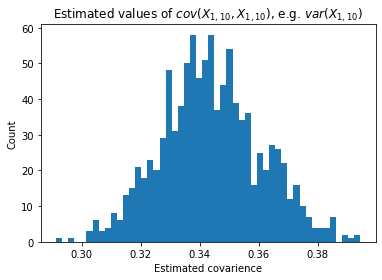

In [4]:
import matplotlib.pyplot as plt

def plot_covariance_estimate(i: int, j: int, n: int, nsamples: int = 1000) -> None:
    """Plot a histogram of covariance estimates.
    
    Args:
        i: the first order statistic index
        j: the second order statistic index
        nsamples: the number of samples to take to calculate the statistic
    """
    estimates = []
    for _k in range(nsamples):
        estimates.append(order_statistic_gauss_covariance(i, j, n, batch_size=1000))
    plt.hist(estimates, bins=50)
    plt.title(r"Estimated values of $cov(X_{1,10}, X_{1,10})$, e.g. $var(X_{1,10})$")
    plt.xlabel("Estimated covarience")
    plt.ylabel("Count")
    plt.show()
    
plot_covariance_estimate(1, 1, 10)

## Calculating the W statistic

The estimated population mean is given as usual by $\hat{\mu} = N^{-1} \sum_{i=1}^N x_i$. However, the standard deviation is given by a more complex formula. I am sure some professionals are familiar with this result, but it was my first time encountering it, so I will include a more detailed discussion.

The authors cite two previous papers [*On least squares and linear combination of observations*, a 1935 paper by Alexander Aitken](https://www.cambridge.org/core/journals/proceedings-of-the-royal-society-of-edinburgh/article/abs/ivon-least-squares-and-linear-combination-of-observations/7106C26F19F2EBF75BCEE7FA285780B9), and [*Least squares estimation of location and scale parameters using order statistics*, a 1952 paper by E.H. Lloyd](https://www.jstor.org/stable/pdf/2332466.pdf).


I was not able to find a copy of the Aitken paper other than Cambridge's pay-walled page. As far as I can tell, it introduces the idea of a generalized least squares regression for fitting models. [Aitken himself](https://en.wikipedia.org/wiki/Alexander_Aitken) is also interesting, being New Zeland's most famous mathematician. I don't believe any one still reading is unfamiliar with the idea of least squares regression, so I will move on to the Lloyd paper.

On the other hand, I could find a copy of the Lloyd paper on Jstor, but I could not find any biographic information about Lloyd. I am not even sure what "E.H." stands for. 

## Digression: The Lloyd paper

The Lloyd paper introduces a method for calculating the mean and standard deviation of symmetric distributions. Say we have a stochastic variable $X$ with a symmetric probability distribution about some mean $\mu$. We can normalize the width of this distribution with a parameter $\sigma$. Therefore, we can rewrite the value $X = \mu + \sigma U$ where $U$ is a stochastic variable with a symmetric distribution about the origin. If we take a sample of $N$ elements from $X$ and order them into $Y_1, Y_2, ..., Y_N$ so that $Y_i \leq Y_{i+1}$, we can construct the series $Z_1, Z_2, ..., Z_N$ where $Z_i = (Y_i - \mu) / \sigma$.

Define $\alpha_i \equiv E[Z_i]$ and $\Omega_{i,j} \equiv cov(Z_i, Z_j)$. Even if the normalized distribution for $U$ is known, but not the parameters $\mu$ and $\sigma$, one can still calculate the values for $\alpha_i$ and $\Omega_{i,j}$.

Here is the clever bit: We then know that $E[Y_i] = \mu + \sigma \alpha_i$, $var(Y_i) = \sigma^2\Omega_{i, i}$ and $cov(T_i, Y_j) = \sigma^2\Omega_{i,j}$. By taking the square root of the later two expressions, we how have a three linear equations linear in $\mu$ and $\sigma$ and can use linear least squares regression to estimate their value. Note: this does not depend on the distribution $U$ being normal, only that it is symmetric.

We can rewrite the above as a vector sum,

$$ E[\overrightarrow{Y}] = \mu \overrightarrow{1} + \sigma \overrightarrow{\alpha} $$

where $\overrightarrow{Y}$ and $\overrightarrow{\alpha}$ are vectors of the $Y_i$ and $\alpha_i$ values and $\overrightarrow{1}$ is a vector of 1's.

Define the matrix $p = [\overrightarrow{1} \overrightarrow{\alpha}]$ as the $(n\times 2)$ matrix and the vector $\overrightarrow{\theta} = [\mu, \sigma]^T$. Therefore $E[\overrightarrow{Y}] = p\overrightarrow{\theta}$

We can also express the covariance matrix for the $Y_i$ as $V[\overrightarrow{Y}] = \sigma^2 \Omega$ where $\Omega$ is the matrix of the $\Omega_{i,j}$ values.

If we estimate $\theta$ as $\overrightarrow{Y} = p\hat{\theta}$ and multiply both sides by $p^T\Omega^{-1}$ and rearrange we get

$$ \hat{\theta} = \Big(p^T \Omega^{-1} p\Big)^{-1} p^T\Omega^{-1} \overrightarrow{Y} $$

We can calculate 

$$ p^T\Omega^{-1}p = \begin{bmatrix} \overrightarrow{1}^T\Omega^{-1}\overrightarrow{1} & \overrightarrow{1}^T\Omega^{-1}\overrightarrow{\alpha} \\ 
\overrightarrow{1}^T\Omega^{-1}\overrightarrow{\alpha} & \overrightarrow{\alpha}^T\Omega^{-1}\overrightarrow{\alpha}
\end{bmatrix}$$

And therefore

$$ \Big(p^T\Omega^{-1}p\Big)^{-1} = \frac{1}{\Delta}\begin{bmatrix} \overrightarrow{\alpha}^T\Omega^{-1}\overrightarrow{\alpha} & 
-\overrightarrow{1}^T\Omega^{-1}\overrightarrow{\alpha} \\ 
-\overrightarrow{1}^T\Omega^{-1}\overrightarrow{\alpha} &
\overrightarrow{1}^T\Omega^{-1}\overrightarrow{1}
\end{bmatrix}$$

where 

$$\Delta = det\Big(p^T\Omega^{-1}p\Big) = \overrightarrow{1}^T\Omega^{-1}\overrightarrow{1} \overrightarrow{\alpha}^T\Omega^{-1}\overrightarrow{\alpha} - (\overrightarrow{1}^T\Omega^{-1}\overrightarrow{\alpha})^2 $$

We can already substitute into the expression for $\hat{\theta}$ to get a closed form expression, but let's keep simplifying.

Let $J$ be a sparse skew-symmetric matrix with 1's along the reverse diagonal. Thus $J = J^T = J^{-1}$. Further $J \overrightarrow{1} = \overrightarrow{1}$

Multiplying a vector by $J$ reverses the order of its elements. For symmetric distributions, $J \overrightarrow{\alpha} = -\overrightarrow{\alpha}$ and $V[\overrightarrow{Y}] = V[-J\overrightarrow{Y}] = \Omega$. Finally note that, $J\Omega J = \Omega$ because $\Omega$ is skew-symmetric, and similarly $J\Omega^{-1}J = \Omega^{-1}$

Therefore

$$ \overrightarrow{1}^T\Omega^{-1}\overrightarrow{\alpha} = 
\overrightarrow{1}^T(J\Omega^{-1}J)(-J\overrightarrow{\alpha}) =
-(\overrightarrow{1}^TJ)\Omega(J^2)\overrightarrow{\alpha} =
-\overrightarrow{1}^T\Omega\overrightarrow{\alpha}
$$

So that $\overrightarrow{1}^T\Omega^{-1}\overrightarrow{\alpha} = 0$.

For symmetric distributions, $\overrightarrow{1}^T\Omega^{-1}\overrightarrow{\alpha} = 0$, so the second term in $\Delta$ is zero and 

$$ \Delta = \overrightarrow{1}^T\Omega^{-1}\overrightarrow{1} \overrightarrow{\alpha}^T\Omega^{-1}\overrightarrow{\alpha}$$

This simplifies the expressions for $\hat{\mu}$ and $\hat{\sigma}$ to 

$$ \hat{\mu} = \frac{\overrightarrow{1}^T\Omega^{-1}\overrightarrow{Y}}{\overrightarrow{1}^T\Omega^{-1}\overrightarrow{1}} $$

$$ \hat{\sigma} = \frac{\overrightarrow{\alpha}^T\Omega^{-1}\overrightarrow{Y}}{\overrightarrow{\alpha}^T\Omega^{-1}\overrightarrow{\alpha}} $$

I should note here that in the Shapiro-Wilk paper, the authors write that 

$$ \hat{\mu} = \frac{\sum_{i=1}^N Y_i}{N} $$

instead of 

$$ \hat{\mu} = \frac{\sum_{i,j=1}^N \omega_{i,j}^{(-1)} Y_j} {\sum_{i,j=1}^N \omega_{i,j}^{(-1)}} $$

This may be an error. Intuitively is seems the authors assertion should be correct for normal distributions, but I could not replicate the result. For it to be true, it must be the case that 

$$ N^{-1} = \frac{\sum_{i=1}^N \omega_{i,j^\prime}^{(-1)}}{\sum_{i,j=1}^N \omega_{i,j}^{(-1)}}  $$

for all $j^\prime \in \{1, 2, ..., N\}$. If there exists an $A$ such that for all $j^\prime \in \{1, 2, ..., N\}$ $\sum_{i=1}^N \omega_{i,j^\prime}^{(-1)} = A$, then the result would hold. 

<!-- see this: https://math.stackexchange.com/questions/2936028/inverse-matrix-sum-of-the-elements-in-each-row -->


## Back to the W statistic

We can then define the W statistic as

$$ W = \frac{\Big(\overrightarrow{\alpha}^T\Omega^{-1}\overrightarrow{Y}\Big)^2}{\lVert\overrightarrow{\alpha}^T \Omega^{-1}\rVert^2\sum_{i=1}^N (Y_i - \bar{Y})^2} $$

We can define

$$ S^2 = \sum_{i=1}^N \Big(Y_i - \bar{Y}\Big)^2 $$

$$ \hat{a}^T = \frac{\overrightarrow{\alpha}^T\Omega^{-1}}{\lVert\overrightarrow{\alpha}^T\Omega^{-1}\rVert} $$

so that we can write $ W = \Big(\hat{a}^T \overrightarrow{Y}\Big)^2 / S^2 $. First, note that the value of $\hat{a}$ only depends on the value of $N$, the number of elements in the sample. As far as I can tell, there is no English explanation of how the statistic works that would lead to any intuition other than the following analysis. I believe this is part of the reason it is still called the "Shapiro-Wilk W statistic".

The statistic for a given sample is invariant to translations and scaling. Intuitively this makes sense because it should be invariant to changes in mean and standard deviation. 

However, we can explicitly show this for the mean by noting that $J\hat{a} = - \hat{a}$ so without loss of generality, we can define $\overrightarrow{Y}^\prime = \overrightarrow{Y} + \lambda\overrightarrow{1}$ so $\bar{Y}^\prime = \bar{Y} + \lambda$. Therefore

$$ W^\prime = \frac{\Big(\hat{a}^T \overrightarrow{Y}^\prime\Big)^2}{S^{\prime2}} $$

But

$$ S^{\prime2} = \sum_{i=1}^N \Big( Y_i^\prime - \bar{Y}^\prime \Big)^2 = \
\sum_{i=1}^N \Big( (Y_i + \lambda) - (\bar{Y} + \lambda) \Big)^2 = \
\sum_{i=1}^N \Big( Y_i - \bar{Y} \Big)^2 = S^2
$$

And

$$ \hat{a}^T\overrightarrow{Y}^\prime = \hat{a}^T(\overrightarrow{Y} + \lambda \overrightarrow{1}) = \hat{a}^T\overrightarrow{Y} + \lambda \hat{a}^T\overrightarrow{1} = \hat{a}^T\overrightarrow{Y}
$$

The last step holds because 

$$ \hat{a}^T\overrightarrow{1} = -(\hat{a}^TJ)\overrightarrow{1} = 
-\hat{a}^T(J\overrightarrow{1}) = -\hat{a}^T\overrightarrow{1} $$

and thus $\hat{a}^T\overrightarrow{1} = 0$.

Substituting the above:

$$ W^\prime = \frac{\Big(\hat{a}^T \overrightarrow{Y}^\prime\Big)^2}{S^{\prime2}} =
\frac{\Big(\hat{a}^T \overrightarrow{Y}\Big)^2}{S^2} = W
$$

Now we show that the statistic is scale invariant. Suppose without loss of generality that $\overrightarrow{Y}^\prime = \lambda\overrightarrow{Y}$. Then 

$$ W^\prime = \frac{\Big(\hat{a}^T \overrightarrow{Y}^\prime\Big)^2}{S^{\prime2}} = \frac{\Big(\hat{a}^T (\lambda \overrightarrow{Y})\Big)^2}{\lambda^2S^2} = \frac{\lambda^2\Big(\hat{a}^T \overrightarrow{Y}\Big)^2}{\lambda^2S^2} = \frac{\Big(\hat{a}^T \overrightarrow{Y}\Big)^2}{S^2} = W $$

Finally we can show the maximum value of $W$ is 1.

Suppose without loss of generality due to translation invariance, that $\bar{Y} = 0$. Then $W = (\hat{a}^T\overrightarrow{Y})^2 / \sum_{i=1}^N Y_i^2$. However, 

$$ \Big(\hat{a}^T \overrightarrow{Y}\Big)^2 = 
\Big(\sum_{i=1}^N a_i Y_i \Big)^2 \leq 
\sum_{i=1}^N a_i^2 \sum_{j=1}^N Y_j^2 =
\sum_{i=1}^N Y_i^2
$$

where $a_i$ is the $i$th element of $\hat{a}$. The last step is true because 
$\lVert \hat{a} \rVert = 1$. The maximum value is clearly when $\overrightarrow{Y} = \lambda \hat{a}$ for some scalar $\lambda$.

This is important because we can write the above Lloyd estimate for population standard deviation as 

$$ \hat{\sigma} = C\hat{a}^T\overrightarrow{Y} $$

where $C$ is a normalization constant. To maximize $\hat{\sigma}$ for a given $S^2$ requires that $\overrightarrow{Y} = \lambda \hat{a}$ for some $\lambda$. Because $\Omega^{-1}$ a concentration matrix, we are finding how much variation in the expected value for the order statistics can be explained by natural variation. But because the distribution of $W$ cannot analytically estimated, we must defer to the Monte-Carlo simulations. 

In [5]:
from typing import Optional
import numpy as np
from scipy import linalg

def order_statistic_gauss_covariance_matrix(N: int, batch_size: int = 10000):
    """Calculate the order statistic covariance matrix for a normal distribution.
    
    Args:
        N: the sample size
        batch_size: the size of the batches used in the Monte-Carlo simulation
    
    Returns:
        An np.array containing the covariance matrix.
    """
    return np.array([[order_statistic_gauss_covariance(row, col, N, batch_size=batch_size) for col in range(N)]
                     for row in range(N)])

def order_statistic_gauss_precision_matrix(N: int, batch_size: int = 10000):
    """Calculate  the order statistic precission matrix for a normal distribution.
    
    Args:
        N: the sample size
        batch_size: the size of the batches used in the Monte-Carlo simulation
    
    Returns:
        An np.array containing the precission matrix.
    """
    return linalg.inv(order_statistic_gauss_covariance_matrix(N, batch_size=batch_size))


def expected_order_statistic_gauss(i: int, N: int) -> float:
    """Get the expected value for the i-th order statistic.
    
    Args:
        i: the index of the order statistic
        N: the number of elements in the sample
    """
    return order_statistic(i, N, lambda x: 0.5 + 0.5*erf(x / (2**0.5)))

from math import sqrt

def shapiro_wilk_coefficients(N: int, batch_size: int = 10000):
    """Calculate the Shapiro-Wilk coefficients.
    
    Args:
        N: the number of samples
        batch_size: the size of the batched used int he Monte-Carlo simulation
        
    Returns:
        The coefficients as an np.array.
    """
    mat = order_statistic_gauss_precision_matrix(N, batch_size=batch_size)
    order_stats = np.array([expected_order_statistic_gauss(
        i, N) for i in range(1, N+1)]).T
    a = (order_stats.dot(mat)).T
    return a / sqrt(a.T.dot(a))

def W_statistic(x: List[float], cached_coefficients: Optional[np.array] = None) -> float:
    """Calculate the W statistic for a sample.
    
    Args:
        x: the sample
        cached_coefficients: optionally cached Shapiro-Wilk coefficients
    
    Returns:
        The W statistic
    """
    N = len(x)
    y = sorted(x)
    a = cached_coefficients if cached_coefficients is not None else shapiro_wilk_coefficients(N)
    x_bar = sum(x) / float(len(x))
    return a.T.dot(np.array(y))**2 / sum([(xx - x_bar)**2 for xx in x]) 
             


Now we can run some Monte-Carlo simulations to figure out the significant values for $W$. The lower $W$ is, the more likely the sample is not from a normal distribution. The following will replicate Table 6 from the Shapiro-Wilk paper. 

In [6]:
def print_table_6(low: int = 3, hi: int = 50, nsamples: int=1000) -> None:
    """Print the data in Table 6 from the Sapiro Wilk 1964 paper."""
    levels = [0.01, 0.02, 0.05, 0.10, 0.50, 0.90, 0.95, 0.98, 0.99]
    print("N\t" + "\t".join([str(level) for level in levels]))
    for N in range(low, hi+1):
        a = shapiro_wilk_coefficients(N)
        ws = [0.0 for _k in range(nsamples)]
        for idx in range(nsamples):
            sample = [gauss(0, 1) for _kk in range(N)]
            ws[idx] = W_statistic(sample, cached_coefficients=a)
        ws = sorted(ws)
        cutoffs = [0 for _k in range(len(levels))]
        for idx in range(len(levels)):
            cutoffs[idx] = ws[int(nsamples*levels[idx])]
        print(str(N)+"\t"+"\t".join([str(cutoff)[:5] for cutoff in cutoffs]))
    return
    
print_table_6(hi=5)

N	0.01	0.02	0.05	0.1	0.5	0.9	0.95	0.98	0.99
3	0.507	0.517	0.550	0.602	0.934	0.996	1.001	1.008	1.015
4	0.501	0.529	0.579	0.614	0.840	0.976	0.989	0.996	0.999
5	0.518	0.541	0.579	0.611	0.776	0.946	0.968	0.981	0.988


Comparing against the original paper, we can already see these numbers are pretty far off from those in the table from the paper. I suspect this is because of the error in the covariance matrix which is amplified by inversion. That said, with larger samples, this is exactly how Shapiro, Wilk, and H.J. Chen used in their 1968 paper examining the power of the test.

TODO(gs): It looks like the cutoffs are always lower than they should be. Investigate why the error is asymmetric. 

Anyways, I might come back to this and go over some other tests of normality. Candidates include

- Anderson-Darling
- Kolmogorov-Smirnov
- Shapiro-Francia